In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
import andreap
from scipy.interpolate import interp1d

import importlib.util
import sys

In [2]:
test_index = 0
validation_set = False
# skips comparison with Andrea's code
fast = False

In [3]:
''' This messiness is necessary to import scripts which are not installed and
which are not located in the cwd.'''

spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../cassL/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

spec = importlib.util.spec_from_file_location(
    "generate_emu_data", "../../cassL/generate_emu_data.py")
ged = importlib.util.module_from_spec(spec)
sys.modules["generate_emu_data"] = ged
spec.loader.exec_module(ged)

In [4]:
hc = np.load("hc_G3_redo.npy",
    allow_pickle=True)
samples = np.load("samples_G3_redo.npy",
    allow_pickle=True)

if False:
    hc = np.load("hc_backup_i4999_massive_pred_revised.npy",
        allow_pickle=True)
    samples = np.load("samples_backup_i4999_massive_pred_revised.npy",
        allow_pickle=True)

if validation_set:
    hc = np.load("hc_test_G3.npy",
        allow_pickle=True)
    samples = np.load("samples_test_G3.npy",
        allow_pickle=True)
    
standard_k = np.load("standard_k.npy", allow_pickle=True)

In [5]:
test_cosmology = hc[test_index]
test_pspec = samples[test_index]

In [6]:
ombh2 = test_cosmology[0]
omch2 = test_cosmology[1]
ns = test_cosmology[2]
sigma12 = test_cosmology[3]
As = test_cosmology[4]
omnuh2 = test_cosmology[5]

In [7]:
full_cosm = ged.build_cosmology(
    ombh2, omch2, ns, sigma12, As, omnuh2)

In [8]:
mnu = full_cosm['mnu']

In [9]:
# Comprehensive checking function
def get_sigma12_interpolator(ombh2, omch2, ns, mnu, h, As):
    Pk = andreap.get_PK(ombh2, omch2, ns, mnu, h * 100, As, w_mzero=True)
    NUM_Z_POINTS=150
    
    z = np.linspace(0., 9., NUM_Z_POINTS)
    sig12 = np.zeros(NUM_Z_POINTS)
    for i in range(NUM_Z_POINTS):
        sig12[i] = andreap.get_s12(Pk['mzero'], z[i])
    
    return interp1d(sig12, z, kind='cubic')

In [10]:
def validate_results(interpolator, sigma12, best_z):
    interpolator_best_z = None
    try:
        interpolator_best_z = interpolator(sigma12)
    except ValueError:
        print("The desired sigma12 is not attainable with this interpolator!")
        return
    
    # print(best_z is None, interpolator_best_z is None)
    
    print("% discrepancy between results for best redshift:",
          (best_z - interpolator_best_z) / interpolator_best_z * 100)

In [21]:
g_pspec, g_sigma12, g_rescale_params = ged.evaluate_cell(
    full_cosm, standard_k, debug=False)
print("This is our approximation", g_sigma12)
g_z = g_rescale_params[1]

We had to move h to 0.57
This is our approximation 0.9719201815328333


In [22]:
s12i_hi_h = get_sigma12_interpolator(
    ombh2, omch2, ns, mnu, .57, As)
print()
validate_results(s12i_hi_h, sigma12, g_z)
print()
validate_results(s12i_hi_h, g_sigma12, g_z)

Physical density in massive neutrinos 0.008207
Number of massive neutrinos: 1
Massive-neutrino sigma12: [0.80262619]
Massless-neutrino sigma12: [1.00397832]

% discrepancy between results for best redshift: 0.10365758201466051

% discrepancy between results for best redshift: 0.10168972966687763


In [23]:
z_best_andrea = s12i_hi_h(0.971921597558254)
z_best_andrea

array(0.05160246)

In [16]:
import copy as cp
MEMNeC = cp.deepcopy(full_cosm)
MEMNeC['omch2'] += MEMNeC['omnuh2']
MEMNeC = ci.specify_neutrino_mass(MEMNeC, 0, 0)

In [17]:
kci_t, zci_t, pci, sci_t = ci.evaluate_cosmology(MEMNeC,
    redshifts=[z_best_andrea], k_points=300)

In [24]:
print("% error in sigma12 for redshift given by Andrea's code:")
(sci_t - g_sigma12) / g_sigma12 * 100

% error in sigma12 for redshift given by Andrea's code:


array([0.0034377])

In [25]:
kci, zci, pci, sci = ci.evaluate_cosmology(
    full_cosm, redshifts=[z_best_andrea],
    k_points=300)

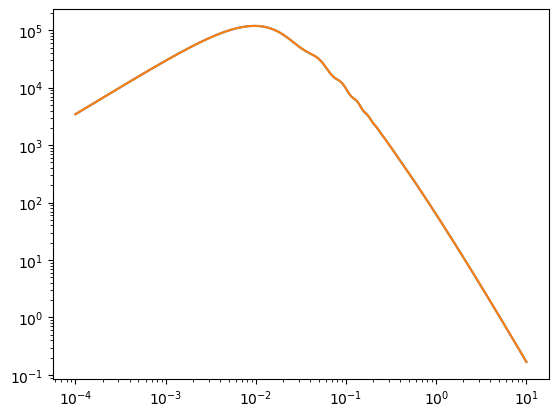

In [26]:
plt.loglog(standard_k, g_pspec, label="ged")
plt.loglog(standard_k, pci, label="Andrea")

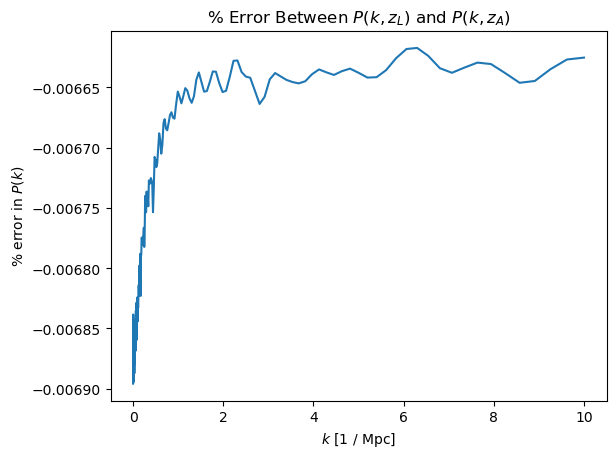

In [32]:
plt.plot(standard_k, (g_pspec - pci) / pci * 100, label="errors")
plt.title("% Error Between $P(k, z_L)$ and $P(k, z_A)$")
plt.xlabel("$k$ [1 / Mpc]")
plt.ylabel("% error in $P(k)$")
plt.savefig("../plots/emulator/debugging/z_discrepancy.png")

What did this notebook teach us? That the differences that we see in the optimum z values are not significant. That is, it's not important that Andrea's code returns a best z value that is slightly different from the one my code returns.